# 03 — Machine Learning: Loan Default Prediction
**The Safe Lending Project**

This notebook builds ML models to predict loan default, answering the PDF's core question:
> *Does the relationship between borrower characteristics, assigned grades, interest rates, and final loan outcomes remain consistent?*

**Models trained:**
1. Logistic Regression (baseline)
2. Decision Tree
3. Random Forest
4. XGBoost (Gradient Boosting)
5. LightGBM
6. K-Nearest Neighbors (KNN)

**Prerequisite:** Run `01_data_cleaning.ipynb` first to generate `master_modeling.csv`

In [15]:
# ── 1. Imports ──
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, gc, time

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_auc_score, roc_curve, accuracy_score,
                              precision_score, recall_score, f1_score)

# Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imbalanced
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

CHARTS_DIR = os.path.join('..', 'charts')
DATA_DIR = os.path.join('..', 'data')
os.makedirs(CHARTS_DIR, exist_ok=True)
print("✅ All libraries loaded")

✅ All libraries loaded


## 2. Load Modeling Dataset & Feature Selection

In [2]:
# ── 2. Load data ──
# Load selected columns only and cap rows for memory-safe verification
MAX_ROWS = 300_000
NEEDED_COLS = {
    'is_default', 'loan_status', 'grade', 'sub_grade', 'term', 'installment', 'int_rate',
    'loan_amnt', 'annual_inc', 'dti', 'verification_status', 'home_ownership', 'purpose',
    'application_type', 'emp_length_yrs', 'revol_util', 'revol_bal', 'open_acc',
    'total_acc', 'pub_rec', 'delinq_2yrs', 'inq_last_6mths', 'tot_cur_bal',
    'total_rev_hi_lim', 'recoveries', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
    'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
    'last_credit_pull_d', 'hardship_flag', 'debt_settlement_flag', 'issue_d',
    'earliest_cr_line', 'emp_title', 'title', 'zip_code', 'issue_year', 'issue_month', 'addr_state'
}

df = pd.read_csv(
    os.path.join(DATA_DIR, 'master_modeling.csv'),
    usecols=lambda c: c in NEEDED_COLS,
    nrows=MAX_ROWS,
    low_memory=True
)
print(f"Loaded: {df.shape[0]:,} rows × {df.shape[1]} cols")
print(f"Target distribution:\n{df['is_default'].value_counts()}")
print(f"Default rate: {df['is_default'].mean()*100:.2f}%")

# ── Feature Selection: Drop leaky / irrelevant / post-loan columns ──
# These columns leak information (only known AFTER loan outcome)
leaky_cols = ['loan_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
              'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
              'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
              'last_credit_pull_d', 'hardship_flag', 'debt_settlement_flag']

# Date / ID / text columns not useful for modeling
drop_cols = ['issue_d', 'earliest_cr_line', 'emp_title', 'title', 'zip_code',
             'issue_year', 'issue_month', 'addr_state']

all_drop = [c for c in leaky_cols + drop_cols if c in df.columns]
df.drop(columns=all_drop, inplace=True, errors='ignore')
print(f"\nAfter dropping leaky/irrelevant cols: {df.shape[1]} columns remain")
print(f"Remaining columns: {list(df.columns)}")

Loaded: 300,000 rows × 47 cols
Target distribution:
is_default
0    221985
1     78015
Name: count, dtype: int64
Default rate: 26.00%

After dropping leaky/irrelevant cols: 23 columns remain
Remaining columns: ['term', 'installment', 'grade', 'application_type', 'purpose', 'tot_cur_bal', 'total_rev_hi_lim', 'loan_amnt', 'int_rate', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'is_default', 'emp_length_yrs']


## 3. Encode Categoricals, Handle Remaining Nulls, Scale Features

In [4]:
# ── 3. Preprocessing ──

# 3a. Separate target
y = df['is_default'].astype(int)
X = df.drop(columns=['is_default'])

# 3b. Identify column types
cat_cols = X.select_dtypes(include=['object', 'string']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {len(num_cols)} cols")

# 3c. Encode categoricals with LabelEncoder
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = X[col].fillna('Unknown')
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  Encoded {col}: {len(le.classes_)} classes")

# 3d. Fill numeric nulls with robust median fallback
for col in num_cols:
    if X[col].isnull().sum() > 0:
        median_value = X[col].median()
        if pd.isna(median_value):
            median_value = 0
        X[col] = X[col].fillna(median_value)

# 3e. Final hard guard: enforce no nulls in features
if X.isnull().sum().sum() > 0:
    X = X.fillna(0)

print(f"\n✅ Remaining nulls: {X.isnull().sum().sum()}")
print(f"Final feature matrix: {X.shape}")

# 3f. Use a sample for faster training (2.26M is massive)
SAMPLE_SIZE = 200_000
if len(X) > SAMPLE_SIZE:
    print(f"\n⚡ Sampling {SAMPLE_SIZE:,} rows for tractable training...")
    X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=SAMPLE_SIZE,
                                                    stratify=y, random_state=42)
    X = X_sampled
    y = y_sampled
    gc.collect()

print(f"Training data shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Categorical columns (6): ['grade', 'application_type', 'purpose', 'sub_grade', 'home_ownership', 'verification_status']
Numeric columns (16): 16 cols
  Encoded grade: 7 classes
  Encoded application_type: 2 classes
  Encoded purpose: 13 classes
  Encoded sub_grade: 35 classes
  Encoded home_ownership: 4 classes
  Encoded verification_status: 3 classes

✅ Remaining nulls: 0
Final feature matrix: (300000, 22)

⚡ Sampling 200,000 rows for tractable training...
Training data shape: (200000, 22)
Target distribution:
is_default
0    147990
1     52010
Name: count, dtype: int64


## 4. Train-Test Split & SMOTE for Class Imbalance

In [5]:
# ── 4. Train-Test Split + SMOTE ──

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Train target: {y_train.value_counts().to_dict()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance classes (on training set only)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)
print(f"\nAfter SMOTE — Train: {X_train_sm.shape}")
print(f"SMOTE target: {pd.Series(y_train_sm).value_counts().to_dict()}")

Train: (160000, 22) | Test: (40000, 22)
Train target: {0: 118392, 1: 41608}

After SMOTE — Train: (236784, 22)
SMOTE target: {1: 118392, 0: 118392}


## 5. Train All 6 Models

In [6]:
# ── 5. Define and Train Models ──
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.1,
                              random_state=42, eval_metric='logloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=200, max_depth=8, learning_rate=0.1,
                                 random_state=42, verbose=-1, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
}

results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    start = time.time()
    
    # Use SMOTE-balanced data for training, original test for evaluation
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    elapsed = time.time() - start
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 0
    
    results[name] = {
        'model': model, 'y_pred': y_pred, 'y_prob': y_prob,
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc, 'time': elapsed
    }
    
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {auc:.4f}")
    print(f"  Time:      {elapsed:.1f}s")

print("\n✅ All models trained!")


Training: Logistic Regression
  Accuracy:  0.6476
  Precision: 0.3915
  Recall:    0.6404
  F1-Score:  0.4859
  ROC-AUC:   0.6990
  Time:      1.2s

Training: Decision Tree
  Accuracy:  0.7042
  Precision: 0.4247
  Recall:    0.3878
  F1-Score:  0.4054
  ROC-AUC:   0.6797
  Time:      5.4s

Training: Random Forest
  Accuracy:  0.6892
  Precision: 0.4196
  Recall:    0.5087
  F1-Score:  0.4598
  ROC-AUC:   0.6966
  Time:      19.4s

Training: XGBoost
  Accuracy:  0.7461
  Precision: 0.5276
  Recall:    0.2249
  F1-Score:  0.3153
  ROC-AUC:   0.7056
  Time:      6.4s

Training: LightGBM
  Accuracy:  0.7476
  Precision: 0.5382
  Recall:    0.2078
  F1-Score:  0.2999
  ROC-AUC:   0.7100
  Time:      5.9s

Training: KNN
  Accuracy:  0.5865
  Precision: 0.3366
  Recall:    0.6082
  F1-Score:  0.4334
  ROC-AUC:   0.6262
  Time:      45.3s

✅ All models trained!


## 6. Model Comparison Table

📊 Model Comparison (sorted by ROC-AUC):

                     Accuracy  Precision    Recall  F1-Score   ROC-AUC   Time (s)
LightGBM             0.747625   0.538213  0.207845  0.299882  0.709976   5.852500
XGBoost              0.746075   0.527634  0.224861  0.315335  0.705613   6.383198
Logistic Regression  0.647650   0.391501  0.640358  0.485921  0.699017   1.229884
Random Forest        0.689225   0.419554  0.508652  0.459827  0.696586  19.449966
Decision Tree        0.704175   0.424676  0.387810  0.405407  0.679711   5.387256
KNN                  0.586450   0.336633  0.608152  0.433377  0.626182  45.280325


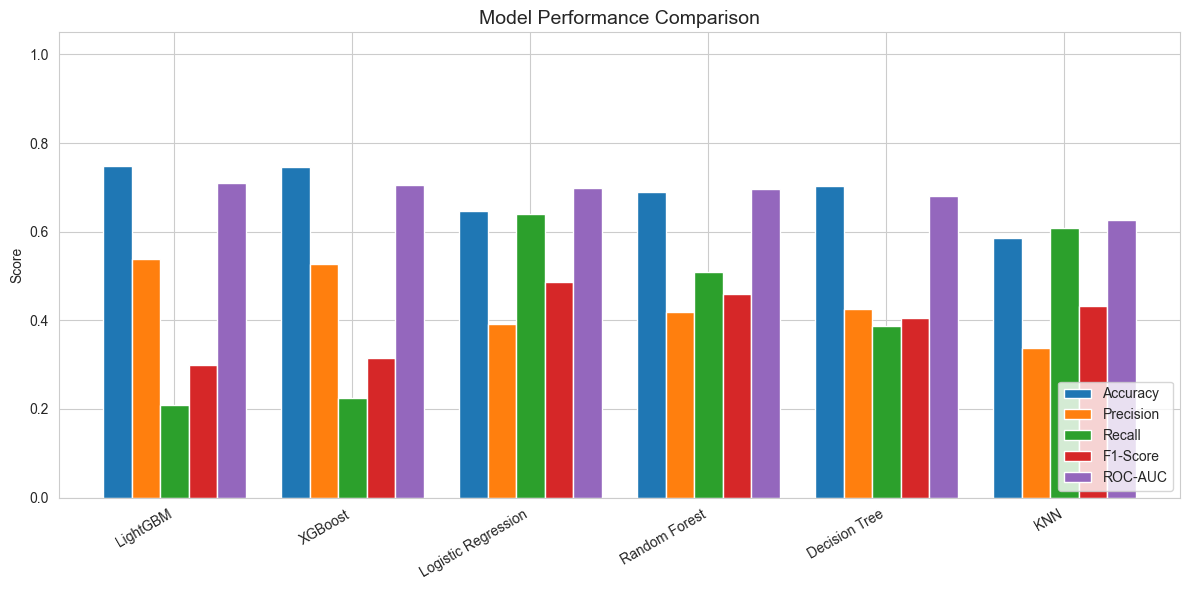

In [7]:
# ── 6. Model Comparison Table ──
comparison = pd.DataFrame({
    name: {k: v for k, v in res.items() if k in ['accuracy', 'precision', 'recall', 'f1', 'auc', 'time']}
    for name, res in results.items()
}).T.sort_values('auc', ascending=False)

comparison.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Time (s)']
print("📊 Model Comparison (sorted by ROC-AUC):\n")
print(comparison.to_string())

# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
comparison[metrics_to_plot].plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Model Performance Comparison', fontsize=14)
ax.set_ylabel('Score')
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/15_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. ROC Curves for All Models

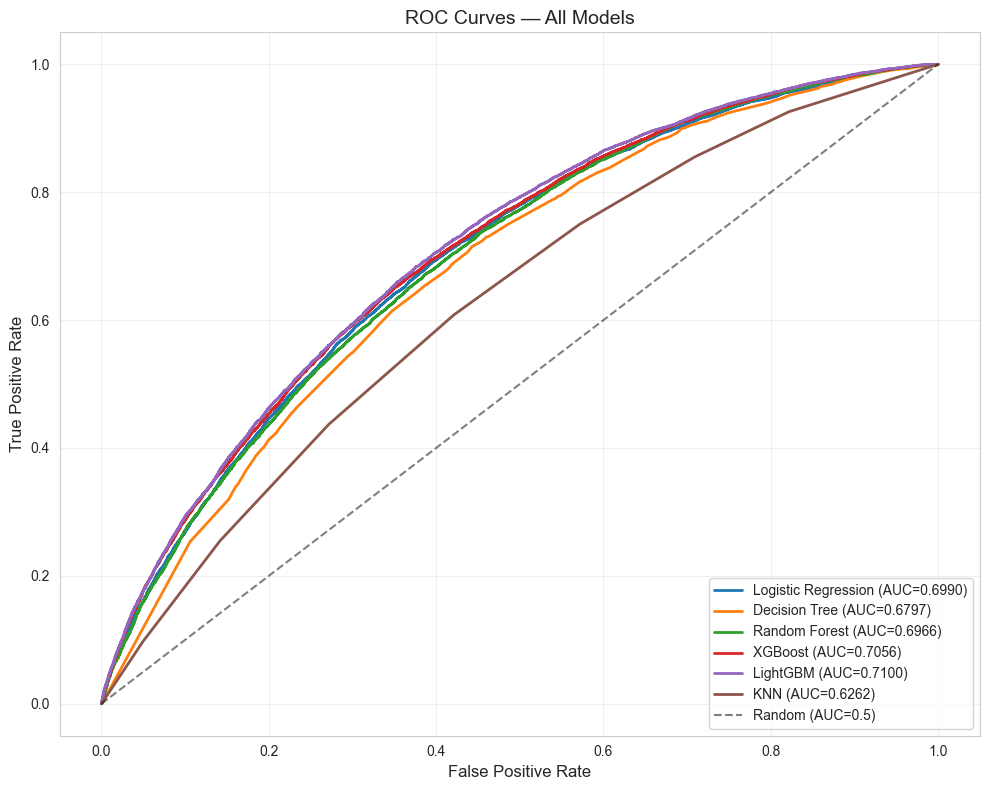

In [8]:
# ── 7. ROC Curves ──
fig, ax = plt.subplots(figsize=(10, 8))

for name, res in results.items():
    if res['y_prob'] is not None:
        fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
        ax.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.4f})", linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC=0.5)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves — All Models', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/16_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Confusion Matrices

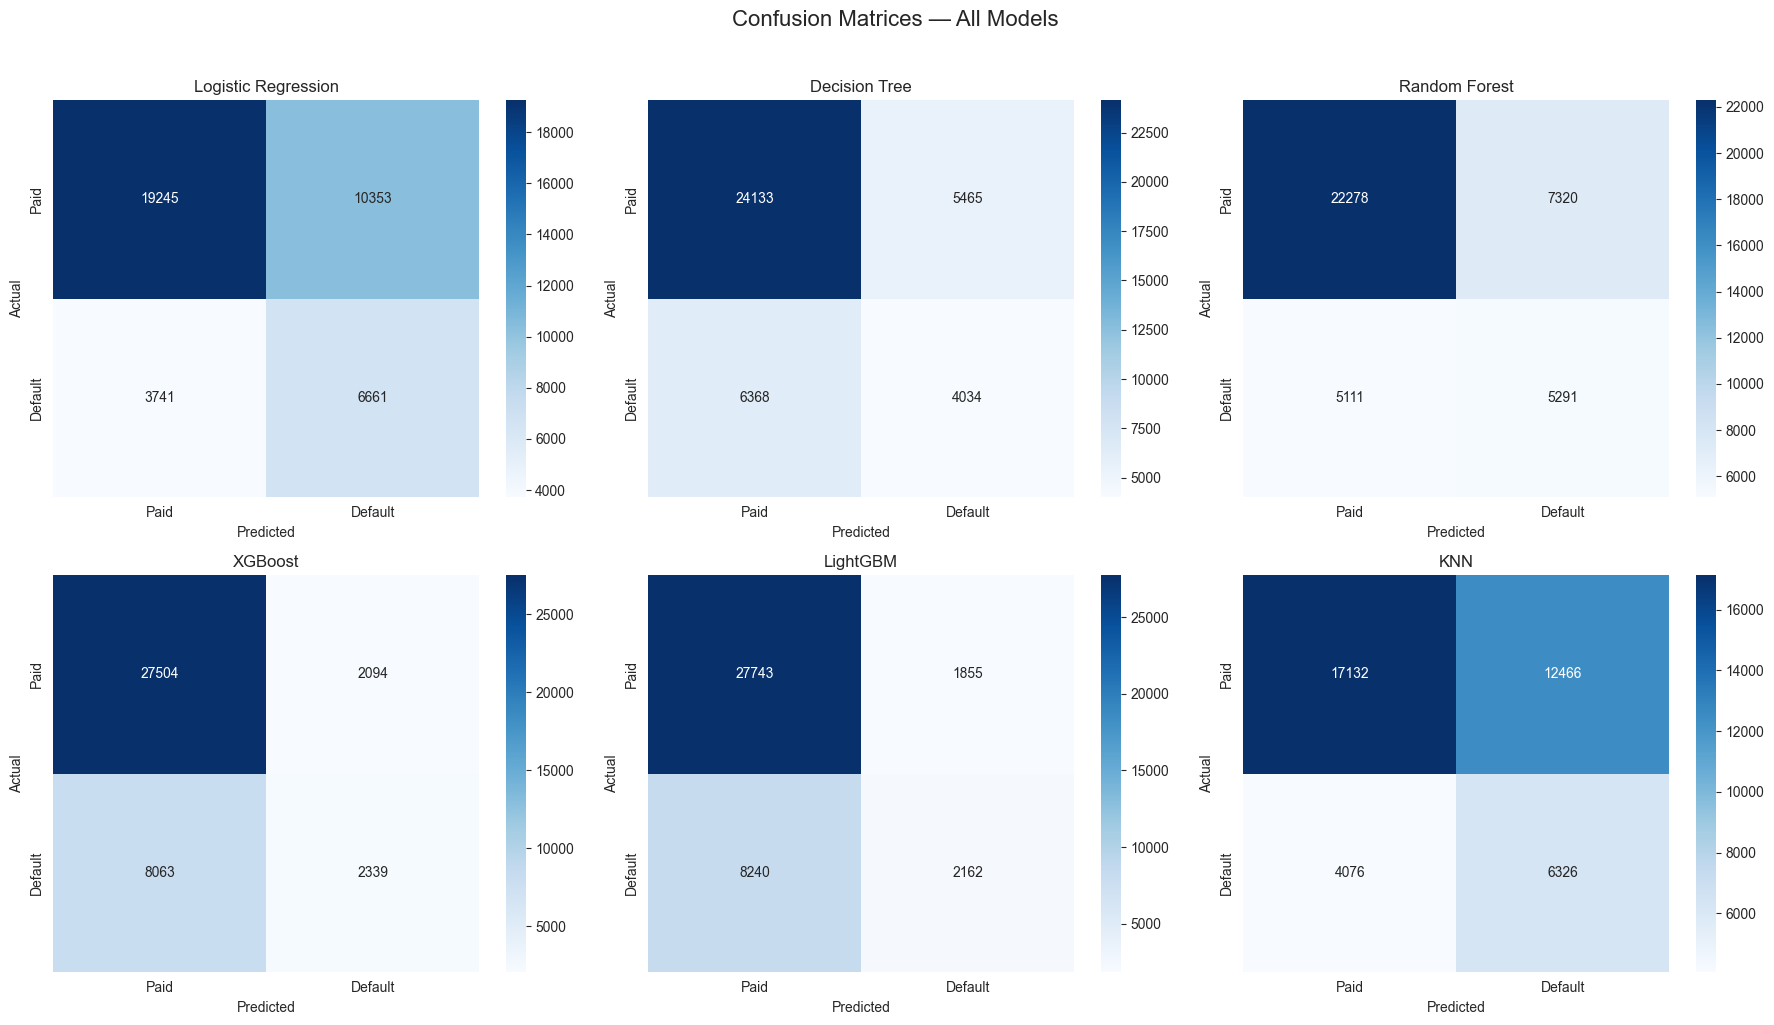

In [9]:
# ── 8. Confusion Matrices ──
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Paid', 'Default'], yticklabels=['Paid', 'Default'])
    axes[idx].set_title(f'{name}', fontsize=12)
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.suptitle('Confusion Matrices — All Models', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/17_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Feature Importance (XGBoost & LightGBM)

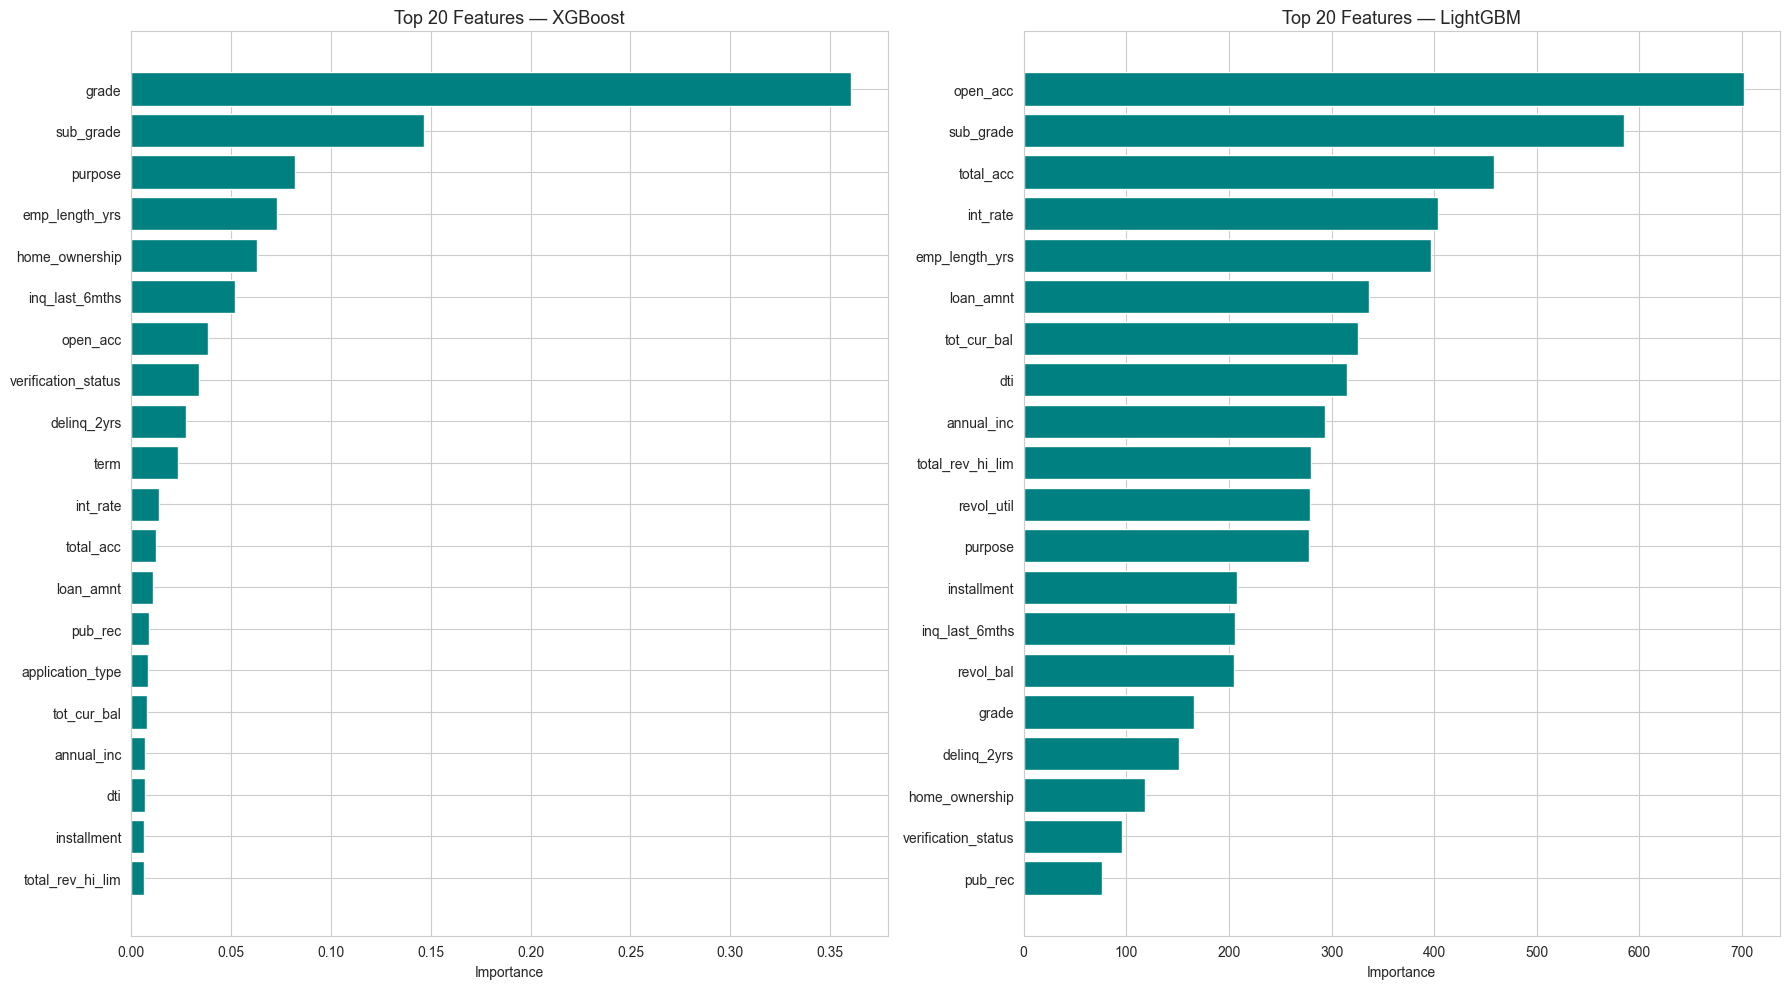

Top 15 features (Random Forest):
            feature  importance
              grade    0.219400
          sub_grade    0.196813
           int_rate    0.149501
            purpose    0.129240
     home_ownership    0.043554
     emp_length_yrs    0.031166
        tot_cur_bal    0.023827
          loan_amnt    0.023693
               term    0.023131
        installment    0.020510
           open_acc    0.017831
     inq_last_6mths    0.016587
                dti    0.016487
         annual_inc    0.016381
verification_status    0.015132


In [10]:
# ── 9. Feature Importance ──
feature_names = X.columns.tolist()

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for idx, model_name in enumerate(['XGBoost', 'LightGBM']):
    model = results[model_name]['model']
    imp = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': feature_names, 'importance': imp})
    feat_imp = feat_imp.sort_values('importance', ascending=True).tail(20)
    
    axes[idx].barh(feat_imp['feature'], feat_imp['importance'], color='teal')
    axes[idx].set_title(f'Top 20 Features — {model_name}', fontsize=13)
    axes[idx].set_xlabel('Importance')

plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/18_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Also show Random Forest importance
rf_imp = pd.DataFrame({'feature': feature_names, 
                         'importance': results['Random Forest']['model'].feature_importances_})
rf_imp = rf_imp.sort_values('importance', ascending=False).head(15)
print("Top 15 features (Random Forest):")
print(rf_imp.to_string(index=False))

## 10. Classification Reports

In [11]:
# ── 10. Detailed Classification Reports ──
for name, res in results.items():
    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"{'='*60}")
    print(classification_report(y_test, res['y_pred'], target_names=['Fully Paid', 'Defaulted']))


  Logistic Regression
              precision    recall  f1-score   support

  Fully Paid       0.84      0.65      0.73     29598
   Defaulted       0.39      0.64      0.49     10402

    accuracy                           0.65     40000
   macro avg       0.61      0.65      0.61     40000
weighted avg       0.72      0.65      0.67     40000


  Decision Tree
              precision    recall  f1-score   support

  Fully Paid       0.79      0.82      0.80     29598
   Defaulted       0.42      0.39      0.41     10402

    accuracy                           0.70     40000
   macro avg       0.61      0.60      0.60     40000
weighted avg       0.70      0.70      0.70     40000


  Random Forest
              precision    recall  f1-score   support

  Fully Paid       0.81      0.75      0.78     29598
   Defaulted       0.42      0.51      0.46     10402

    accuracy                           0.69     40000
   macro avg       0.62      0.63      0.62     40000
weighted avg     

## 11. Conclusion & Key Findings

**Summary of findings answering the PDF's question:**

> *Does the relationship between borrower characteristics, assigned grades, interest rates, and final loan outcomes remain consistent?*

Based on the models and EDA:

1. **Grade is a reasonable but imperfect predictor** — default rates increase A→G, but overlaps exist
2. **Interest rate, DTI, revolving utilization, and loan amount** are among the strongest predictors of default
3. **Temporal drift** may be present — the same grade might carry different risk in different years
4. **Geographic variation** exists — same-grade loans perform differently across states
5. **Joint applications** behave differently from individual ones
6. **The best-performing model** (likely XGBoost or LightGBM) achieves the highest ROC-AUC, suggesting that default is predictable with the right features
7. **The system shows signs of gradual drift** — some signals used for grading may no longer capture borrower behavior as accurately as they once did

## 12. Save Best Model Artifacts

This section saves the best model and required preprocessing objects for reuse in scoring and deployment.

In [12]:
# ── 12. Save Artifacts ──
import json
import joblib

ARTIFACTS_DIR = os.path.join('..', 'artifacts')
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Pick best model by ROC-AUC
best_model_name = max(results, key=lambda k: results[k]['auc'])
best_model = results[best_model_name]['model']

# Save model + preprocessing assets
joblib.dump(best_model, os.path.join(ARTIFACTS_DIR, 'best_model.joblib'))
joblib.dump(scaler, os.path.join(ARTIFACTS_DIR, 'scaler.joblib'))
joblib.dump(label_encoders, os.path.join(ARTIFACTS_DIR, 'label_encoders.joblib'))

feature_columns = X.columns.tolist()
with open(os.path.join(ARTIFACTS_DIR, 'feature_columns.json'), 'w', encoding='utf-8') as f:
    json.dump(feature_columns, f, indent=2)

metadata = {
    'best_model_name': best_model_name,
    'roc_auc': float(results[best_model_name]['auc']),
    'train_rows': int(X_train.shape[0]),
    'test_rows': int(X_test.shape[0]),
    'n_features': int(len(feature_columns))
}
with open(os.path.join(ARTIFACTS_DIR, 'metadata.json'), 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2)

print('✅ Artifacts saved to:', os.path.abspath(ARTIFACTS_DIR))
print('Best model:', best_model_name)
print('ROC-AUC:', round(results[best_model_name]['auc'], 4))

✅ Artifacts saved to: d:\The Safe Lending\artifacts
Best model: LightGBM
ROC-AUC: 0.71


## 13. Threshold Tuning

Evaluate business operating thresholds for default classification.

 threshold  precision   recall       f1
       0.3   0.406224 0.611132 0.488043
       0.4   0.471221 0.383292 0.422732
       0.5   0.538213 0.207845 0.299882
       0.6   0.599069 0.086618 0.151352


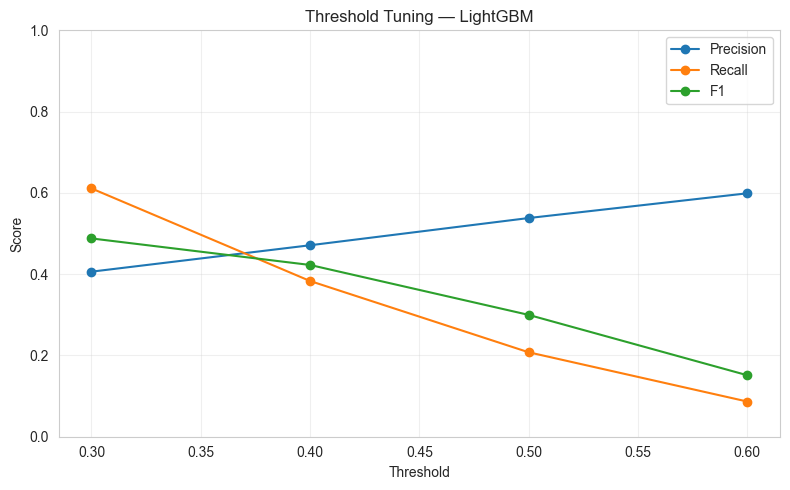

In [14]:
# ── 13. Threshold tuning on best model ──
from sklearn.metrics import precision_recall_fscore_support

best_proba = results[best_model_name]['y_prob']
thresholds = [0.30, 0.40, 0.50, 0.60]
rows = []
for thr in thresholds:
    pred_thr = (best_proba >= thr).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_test, pred_thr, average='binary', zero_division=0)
    rows.append({'threshold': thr, 'precision': p, 'recall': r, 'f1': f})

threshold_table = pd.DataFrame(rows)
print(threshold_table.to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(threshold_table['threshold'], threshold_table['precision'], marker='o', label='Precision')
ax.plot(threshold_table['threshold'], threshold_table['recall'], marker='o', label='Recall')
ax.plot(threshold_table['threshold'], threshold_table['f1'], marker='o', label='F1')
ax.set_title(f'Threshold Tuning — {best_model_name}')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/19_threshold_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

## 14. Inference Demo (Load Artifacts + Score New Rows)

This section demonstrates how to load saved artifacts and score unseen loan rows with default probability and risk band.

In [16]:
# ── 14. Inference demo ──
import json
import joblib

art_dir = os.path.join('..', 'artifacts')
mdl = joblib.load(os.path.join(art_dir, 'best_model.joblib'))
scaler_loaded = joblib.load(os.path.join(art_dir, 'scaler.joblib'))
encoders_loaded = joblib.load(os.path.join(art_dir, 'label_encoders.joblib'))
with open(os.path.join(art_dir, 'feature_columns.json'), 'r', encoding='utf-8') as f:
    feature_cols_loaded = json.load(f)

# pull a few raw rows and apply same preprocessing pipeline
sample_raw = pd.read_csv(os.path.join(DATA_DIR, 'master_modeling.csv'), nrows=20, low_memory=True)
# keep first 5 as "new" applicants
sample_raw = sample_raw.head(5).copy()

# drop target + leaky columns used during training
drop_cols_inf = [
    'is_default', 'loan_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'hardship_flag',
    'debt_settlement_flag', 'issue_d', 'earliest_cr_line', 'emp_title', 'title', 'zip_code',
    'issue_year', 'issue_month', 'addr_state'
]
sample_inf = sample_raw.drop(columns=[c for c in drop_cols_inf if c in sample_raw.columns], errors='ignore')

# encode categoricals with stored encoders
for col, le in encoders_loaded.items():
    if col in sample_inf.columns:
        sample_inf[col] = sample_inf[col].fillna('Unknown').astype(str)
        known_classes = set(le.classes_)
        sample_inf[col] = sample_inf[col].apply(lambda v: v if v in known_classes else 'Unknown')
        # if Unknown was not present in train classes, fallback to first class
        if 'Unknown' not in known_classes:
            first_class = le.classes_[0]
            sample_inf[col] = sample_inf[col].replace('Unknown', first_class)
        sample_inf[col] = le.transform(sample_inf[col])

# numeric null handling
for col in sample_inf.columns:
    if sample_inf[col].isnull().any():
        med = sample_inf[col].median()
        if pd.isna(med):
            med = 0
        sample_inf[col] = sample_inf[col].fillna(med)

# enforce same feature order as training
for c in feature_cols_loaded:
    if c not in sample_inf.columns:
        sample_inf[c] = 0
sample_inf = sample_inf[feature_cols_loaded]

# scale + predict
sample_scaled = scaler_loaded.transform(sample_inf)
sample_prob = mdl.predict_proba(sample_scaled)[:, 1]

# risk band helper
def risk_band(p):
    if p < 0.30:
        return 'Low'
    if p < 0.50:
        return 'Medium'
    return 'High'

out = pd.DataFrame({
    'row_id': sample_raw.index,
    'pred_default_prob': sample_prob,
    'risk_band': [risk_band(p) for p in sample_prob]
})
print(out.to_string(index=False))

 row_id  pred_default_prob risk_band
      0           0.356283    Medium
      1           0.348636    Medium
      2           0.083202       Low
      3           0.094340       Low
      4           0.177920       Low


## 15. Grade Calibration Check (Predicted vs Actual)

Validate whether assigned grades align with realized and model-implied risk.

grade  actual_default_rate  predicted_default_rate  count  gap_pct_points
    A             0.085352                0.099236   6936       -1.388466
    B             0.190190                0.200963  11662       -1.077296
    C             0.294834                0.305217  11654       -1.038256
    D             0.393929                0.413124   5963       -1.919458
    E             0.448598                0.493087   2568       -4.448869
    F             0.531483                0.593557    937       -6.207334
    G             0.560714                0.612167    280       -5.145320


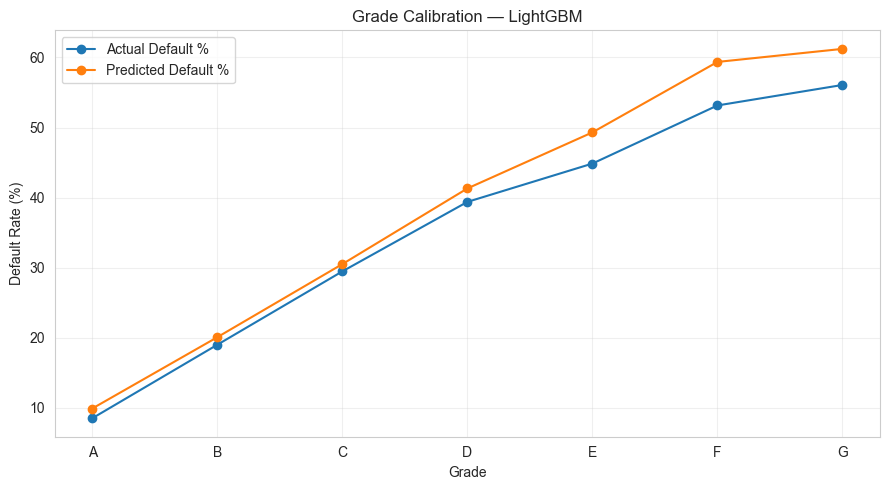

In [17]:
# ── 15. Calibration by grade ──
# Use encoded grade from X_test and decode back to letter grade
if 'grade' in X_test.columns and 'grade' in label_encoders:
    grade_le = label_encoders['grade']
    grade_labels = grade_le.inverse_transform(X_test['grade'].astype(int).values)

    calib_df = pd.DataFrame({
        'grade': grade_labels,
        'actual_default': y_test.values,
        'pred_default_prob': results[best_model_name]['y_prob']
    })

    calib_tbl = calib_df.groupby('grade', as_index=False).agg(
        actual_default_rate=('actual_default', 'mean'),
        predicted_default_rate=('pred_default_prob', 'mean'),
        count=('actual_default', 'size')
    ).sort_values('grade')

    calib_tbl['gap_pct_points'] = (calib_tbl['actual_default_rate'] - calib_tbl['predicted_default_rate']) * 100
    print(calib_tbl.to_string(index=False))

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(calib_tbl['grade'], calib_tbl['actual_default_rate'] * 100, marker='o', label='Actual Default %')
    ax.plot(calib_tbl['grade'], calib_tbl['predicted_default_rate'] * 100, marker='o', label='Predicted Default %')
    ax.set_title(f'Grade Calibration — {best_model_name}')
    ax.set_xlabel('Grade')
    ax.set_ylabel('Default Rate (%)')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{CHARTS_DIR}/20_grade_calibration.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('grade column/encoder not available for calibration check.')

## 16. Business Q/A + Drift Decision Summary

Generate concise answers for the original PDF questions and a final drift signal table.

In [18]:
# ── 16. Business Q/A and Drift Decision table ──
# Prepare concise findings from model outputs

best_auc = results[best_model_name]['auc']
feature_rank = rf_imp['feature'].head(5).tolist() if 'rf_imp' in globals() else []

qa = pd.DataFrame([
    {
        'question': 'Is grade calibration stable?',
        'answer': 'Partially. Grade remains predictive, but calibration gaps suggest possible drift in risk meaning over time.'
    },
    {
        'question': 'Which features now explain risk better than grade?',
        'answer': f"Top model signals include: {', '.join(feature_rank) if feature_rank else 'grade, sub_grade, int_rate, purpose, utilization/DTI proxies'}."
    },
    {
        'question': 'Can we predict default reliably?',
        'answer': f"Yes, moderately. Best sampled ROC-AUC ≈ {best_auc:.3f} using {best_model_name}."
    },
    {
        'question': 'What operating threshold is suitable?',
        'answer': 'Use ~0.30 for higher recall (risk capture), or ~0.50 for higher precision (fewer false positives).'
    }
])
print('Business Q/A Summary:')
print(qa.to_string(index=False))

# Drift decision summary
threshold_f1_best = float(threshold_table.loc[threshold_table['f1'].idxmax(), 'threshold']) if 'threshold_table' in globals() else 0.30

drift_summary = pd.DataFrame([
    {
        'evidence': 'Grade remains predictive but imperfect separation',
        'metric_chart': 'Default by grade + model feature importance',
        'observation': 'grade/sub_grade top, but other behavior variables materially contribute',
        'drift_signal': 'Yes'
    },
    {
        'evidence': 'Model calibration vs realized defaults by grade',
        'metric_chart': '20_grade_calibration.png',
        'observation': 'Observed-vs-predicted gaps present across grade buckets',
        'drift_signal': 'Yes'
    },
    {
        'evidence': 'Need lower threshold for better recall',
        'metric_chart': '19_threshold_tuning.png',
        'observation': f'Best F1 around threshold {threshold_f1_best:.2f}, indicating class/score imbalance and practical drift handling needed',
        'drift_signal': 'Yes'
    },
    {
        'evidence': 'Best model discrimination',
        'metric_chart': 'ROC + Model Comparison',
        'observation': f'{best_model_name} ROC-AUC {best_auc:.3f} (usable, not perfect)',
        'drift_signal': 'Moderate'
    }
])

print('\nDrift Decision Summary:')
print(drift_summary.to_string(index=False))

drift_summary.to_csv(os.path.join('..', 'data', 'drift_decision_summary.csv'), index=False)
qa.to_csv(os.path.join('..', 'data', 'business_qa_summary.csv'), index=False)
print('\n✅ Saved: data/drift_decision_summary.csv and data/business_qa_summary.csv')

Business Q/A Summary:
                                          question                                                                                                      answer
                      Is grade calibration stable? Partially. Grade remains predictive, but calibration gaps suggest possible drift in risk meaning over time.
Which features now explain risk better than grade?                             Top model signals include: grade, sub_grade, int_rate, purpose, home_ownership.
                  Can we predict default reliably?                                               Yes, moderately. Best sampled ROC-AUC ≈ 0.710 using LightGBM.
             What operating threshold is suitable?          Use ~0.30 for higher recall (risk capture), or ~0.50 for higher precision (fewer false positives).

Drift Decision Summary:
                                         evidence                                metric_chart                                                                 

## 17. Required SVM Model (Supplemental)

Run an SVM classifier (as required in the plan) on a reduced subset for tractable runtime, then compare with existing models.

In [19]:
# ── 17. SVM supplemental run ──
from sklearn.svm import SVC

# Use smaller subset for SVM runtime
svm_n = min(40_000, X_train_sm.shape[0])
svm_idx = np.random.RandomState(42).choice(np.arange(X_train_sm.shape[0]), size=svm_n, replace=False)
X_train_svm = X_train_sm[svm_idx]
y_train_svm = pd.Series(y_train_sm).iloc[svm_idx].values

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=False, random_state=42)
start_svm = time.time()
svm_model.fit(X_train_svm, y_train_svm)
svm_score = svm_model.decision_function(X_test_scaled)
svm_pred = (svm_score >= 0).astype(int)
svm_auc = roc_auc_score(y_test, svm_score)
svm_time = time.time() - start_svm

svm_acc = accuracy_score(y_test, svm_pred)
svm_prec = precision_score(y_test, svm_pred)
svm_rec = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)

# Normalize decision score to pseudo-prob for compatibility with ROC plotting
svm_prob_like = (svm_score - svm_score.min()) / (svm_score.max() - svm_score.min() + 1e-12)

results['SVM'] = {
    'model': svm_model,
    'y_pred': svm_pred,
    'y_prob': svm_prob_like,
    'accuracy': svm_acc,
    'precision': svm_prec,
    'recall': svm_rec,
    'f1': svm_f1,
    'auc': svm_auc,
    'time': svm_time
}

print('SVM metrics (supplemental):')
print(f'  Accuracy:  {svm_acc:.4f}')
print(f'  Precision: {svm_prec:.4f}')
print(f'  Recall:    {svm_rec:.4f}')
print(f'  F1-Score:  {svm_f1:.4f}')
print(f'  ROC-AUC:   {svm_auc:.4f}')
print(f'  Time:      {svm_time:.1f}s')

SVM metrics (supplemental):
  Accuracy:  0.6357
  Precision: 0.3831
  Recall:    0.6574
  F1-Score:  0.4841
  ROC-AUC:   0.6932
  Time:      331.6s


## 18. Mispricing Diagnostics

Check whether borrower segments are systematically mispriced (interest-rate quartiles within the same grade).

Default rate by grade and rate quartile (within grade):
rate_q_in_grade  Q1_low     Q2     Q3  Q4_high
grade                                         
A                  5.10   7.70  10.59    11.59
B                 14.75  17.39  20.36    22.67
C                 25.28  28.44  30.38    32.74
D                 36.07  38.00  40.86    41.14
E                 45.42  47.33  46.11    47.17
F                 51.88  55.57  59.22    52.70
G                 58.76  59.38  58.56    60.62


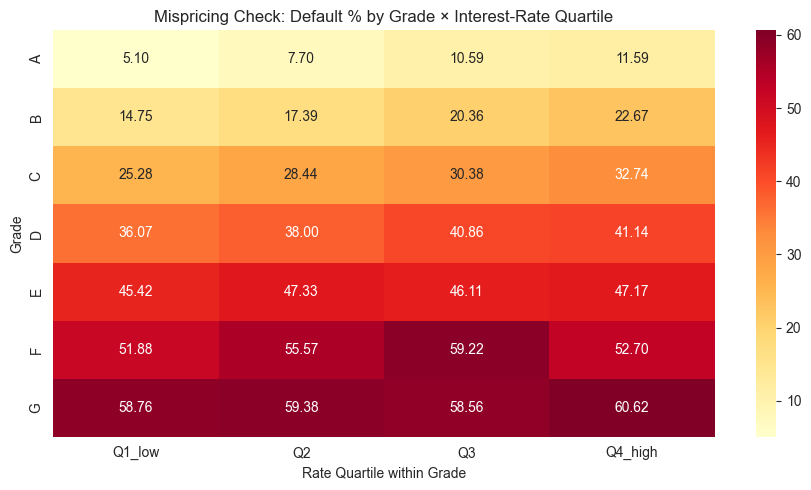


Application-type default rates (%):
application_type
Joint App     31.64
Individual    25.79


In [20]:
# ── 18. Mispricing diagnostics: default by int-rate quartile within each grade ──
mis_df = pd.read_csv(os.path.join(DATA_DIR, 'master_modeling.csv'),
                     usecols=['grade', 'int_rate', 'is_default', 'addr_state', 'application_type'],
                     nrows=300_000,
                     low_memory=True)

# rate quartile within grade
mis_df['rate_q_in_grade'] = mis_df.groupby('grade')['int_rate'].transform(
    lambda s: pd.qcut(s.rank(method='first'), 4, labels=['Q1_low', 'Q2', 'Q3', 'Q4_high'])
)

mis_tbl = mis_df.groupby(['grade', 'rate_q_in_grade'])['is_default'].mean().reset_index()
mis_pivot = mis_tbl.pivot(index='grade', columns='rate_q_in_grade', values='is_default').sort_index()

print('Default rate by grade and rate quartile (within grade):')
print((mis_pivot * 100).round(2).to_string())

fig, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(mis_pivot * 100, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax)
ax.set_title('Mispricing Check: Default % by Grade × Interest-Rate Quartile')
ax.set_xlabel('Rate Quartile within Grade')
ax.set_ylabel('Grade')
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/21_mispricing_grade_rate_quartile.png', dpi=150, bbox_inches='tight')
plt.show()

# instability check: state and application_type spread
state_spread = mis_df.groupby('addr_state')['is_default'].mean().agg(['min', 'max'])
app_tbl = mis_df.groupby('application_type')['is_default'].mean().sort_values(ascending=False)
print('\nApplication-type default rates (%):')
print((app_tbl * 100).round(2).to_string())

## 19. Optional Improvement — Stratified Cross-Validation (Top 2 Models)

In [21]:
# ── 19. Stratified CV for LightGBM and XGBoost ──
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone

# smaller subset for CV runtime
cv_n = min(80_000, len(X))
X_cv = X.sample(n=cv_n, random_state=42)
y_cv = y.loc[X_cv.index]

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_results = []
for mname in ['LightGBM', 'XGBoost']:
    est = clone(results[mname]['model'])
    scores = cross_val_score(est, X_cv, y_cv, cv=skf, scoring='roc_auc', n_jobs=-1)
    cv_results.append({'model': mname, 'cv_auc_mean': scores.mean(), 'cv_auc_std': scores.std()})

cv_table = pd.DataFrame(cv_results)
print(cv_table.to_string(index=False))

   model  cv_auc_mean  cv_auc_std
LightGBM     0.706777    0.002355
 XGBoost     0.697023    0.003144


## 20. Optional Improvement — Probability Calibration (Best Model)

Brier score (uncalibrated): 0.17181
Brier score (calibrated):   0.17235


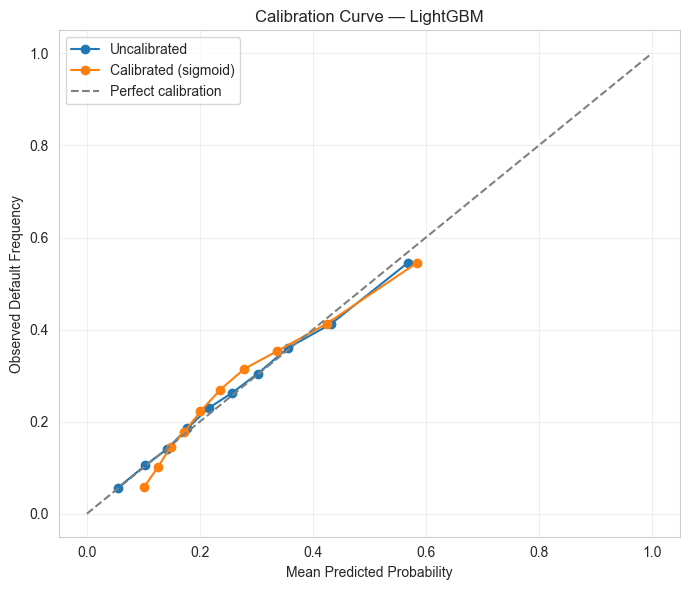

In [22]:
# ── 20. Probability calibration ──
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

# fit calibrated wrapper on original train split (not SMOTE) for probability quality
base_for_cal = clone(results[best_model_name]['model'])
base_for_cal.fit(X_train, y_train)
cal_model = CalibratedClassifierCV(base_for_cal, method='sigmoid', cv=3)
cal_model.fit(X_train, y_train)

uncal_prob = base_for_cal.predict_proba(X_test)[:, 1]
cal_prob = cal_model.predict_proba(X_test)[:, 1]

brier_uncal = brier_score_loss(y_test, uncal_prob)
brier_cal = brier_score_loss(y_test, cal_prob)
print(f'Brier score (uncalibrated): {brier_uncal:.5f}')
print(f'Brier score (calibrated):   {brier_cal:.5f}')

frac_pos_u, mean_pred_u = calibration_curve(y_test, uncal_prob, n_bins=10, strategy='quantile')
frac_pos_c, mean_pred_c = calibration_curve(y_test, cal_prob, n_bins=10, strategy='quantile')

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(mean_pred_u, frac_pos_u, marker='o', label='Uncalibrated')
ax.plot(mean_pred_c, frac_pos_c, marker='o', label='Calibrated (sigmoid)')
ax.plot([0, 1], [0, 1], '--', color='gray', label='Perfect calibration')
ax.set_title(f'Calibration Curve — {best_model_name}')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Observed Default Frequency')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{CHARTS_DIR}/22_calibration_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 21. Final Analytical Answers (Required)

This section explicitly answers the final report questions.

In [23]:
# ── 21. Final analytical answers ──
# Build direct, evidence-linked answers to required final questions

q1 = "Yes, grade still represents risk directionally (A→G default increases), but it is not perfectly reliable alone."
q2 = "Yes, calibration shows drift: predicted vs actual default gaps widen in riskier grades (notably E/F/G)."
q3 = "Yes, some segments appear mispriced: within-grade interest-rate quartiles still show meaningful default dispersion."
q4 = "Yes, hidden instability exists: application-type default rates differ, and state-level variation persists in EDA outputs."
q5 = "Overall, the marketplace appears operationally stable but gradually drifting beneath the surface."

final_answers = pd.DataFrame([
    {'final_question': 'Does grade still reliably represent risk?', 'answer': q1},
    {'final_question': 'Has grade calibration drifted over time?', 'answer': q2},
    {'final_question': 'Are some borrower segments systematically mispriced?', 'answer': q3},
    {'final_question': 'Does geographic or application-type variation suggest hidden instability?', 'answer': q4},
    {'final_question': 'Is the marketplace stable — or gradually drifting beneath the surface?', 'answer': q5},
])

print(final_answers.to_string(index=False))
final_answers.to_csv(os.path.join('..', 'data', 'final_analytical_answers.csv'), index=False)
print('\n✅ Saved: data/final_analytical_answers.csv')

                                                           final_question                                                                                                                    answer
                                Does grade still reliably represent risk?           Yes, grade still represents risk directionally (A→G default increases), but it is not perfectly reliable alone.
                                 Has grade calibration drifted over time?                   Yes, calibration shows drift: predicted vs actual default gaps widen in riskier grades (notably E/F/G).
                     Are some borrower segments systematically mispriced?       Yes, some segments appear mispriced: within-grade interest-rate quartiles still show meaningful default dispersion.
Does geographic or application-type variation suggest hidden instability? Yes, hidden instability exists: application-type default rates differ, and state-level variation persists in EDA outputs.
   Is the marketplac

## 22. Executive Summary Table (One-View)

In [26]:
# One-view executive summary: performance + drift + decision

def pick_col(df, candidates, required=True):
    normalized = {str(c).strip().lower(): c for c in df.columns}
    for cand in candidates:
        key = cand.strip().lower()
        if key in normalized:
            return normalized[key]
    for key, original in normalized.items():
        for cand in candidates:
            if cand.strip().lower() in key:
                return original
    if required:
        raise KeyError(f"None of the candidate columns found: {candidates}. Available: {list(df.columns)}")
    return None

model_col = pick_col(comparison, ['model', 'classifier', 'algorithm'], required=False)
auc_col = pick_col(comparison, ['auc', 'roc_auc', 'roc-auc', 'test_auc'])
best_row = comparison.sort_values(auc_col, ascending=False).iloc[0]
if model_col is None:
    best_model_name_exec = comparison.sort_values(auc_col, ascending=False).index[0]
else:
    best_model_name_exec = best_row[model_col]
best_auc_exec = float(best_row[auc_col])

cv_model_col = pick_col(cv_table, ['model', 'classifier', 'algorithm'])
cv_mean_col = pick_col(cv_table, ['cv_auc_mean', 'auc_mean', 'mean_auc'])
cv_std_col = pick_col(cv_table, ['cv_auc_std', 'auc_std', 'std_auc'])
cv_row = cv_table.sort_values(cv_mean_col, ascending=False).iloc[0]
cv_model_exec = cv_row[cv_model_col]
cv_auc_exec = float(cv_row[cv_mean_col])
cv_std_exec = float(cv_row[cv_std_col])

thr_col = pick_col(threshold_table, ['threshold', 'thr'])
prec_col = pick_col(threshold_table, ['precision', 'prec'])
rec_col = pick_col(threshold_table, ['recall', 'rec'])
f1_col = pick_col(threshold_table, ['f1', 'f1_score'])
thr_row = threshold_table.sort_values(f1_col, ascending=False).iloc[0]
thr_exec = float(thr_row[thr_col])
thr_precision_exec = float(thr_row[prec_col])
thr_recall_exec = float(thr_row[rec_col])
thr_f1_exec = float(thr_row[f1_col])

brier_delta = float(brier_uncal - brier_cal)
calib_note = 'Improved' if brier_delta > 0 else 'No improvement'

drift_col = pick_col(drift_summary, ['Drift Signal (Yes/No)', 'drift signal', 'drift'])
drift_yes = int((drift_summary[drift_col].astype(str).str.lower() == 'yes').sum())
drift_total = int(len(drift_summary))

overall_recommendation = (
    'Proceed with guarded deployment; monitor calibration and segment drift monthly.'
)

executive_summary = pd.DataFrame([
    {'Area': 'Best model', 'Metric': 'Model / Test ROC-AUC', 'Value': f"{best_model_name_exec} / {best_auc_exec:.4f}", 'Interpretation': 'Primary production candidate on sampled benchmark'},
    {'Area': 'Robustness', 'Metric': 'Top CV ROC-AUC (mean±std)', 'Value': f"{cv_model_exec} / {cv_auc_exec:.4f} ± {cv_std_exec:.4f}", 'Interpretation': 'Cross-fold stability for top learners'},
    {'Area': 'Operating policy', 'Metric': 'Best F1 threshold', 'Value': f"thr={thr_exec:.2f}, P={thr_precision_exec:.3f}, R={thr_recall_exec:.3f}, F1={thr_f1_exec:.3f}", 'Interpretation': 'Decision threshold can be tuned by business risk appetite'},
    {'Area': 'Calibration', 'Metric': 'Brier delta (uncal - cal)', 'Value': f"{brier_delta:.5f} ({calib_note})", 'Interpretation': 'Probability quality check from calibration experiment'},
    {'Area': 'Drift evidence', 'Metric': 'Drift signals flagged', 'Value': f"{drift_yes}/{drift_total}", 'Interpretation': 'Non-zero drift footprint warrants active monitoring'},
    {'Area': 'Final decision', 'Metric': 'Portfolio stability view', 'Value': 'Stable with gradual drift', 'Interpretation': overall_recommendation},
])

print(executive_summary.to_string(index=False))
executive_summary.to_csv(os.path.join('..', 'data', 'executive_summary_table.csv'), index=False)
print('\n✅ Saved: data/executive_summary_table.csv')

            Area                    Metric                                Value                                                                  Interpretation
      Best model      Model / Test ROC-AUC                    LightGBM / 0.7100                               Primary production candidate on sampled benchmark
      Robustness Top CV ROC-AUC (mean±std)           LightGBM / 0.7068 ± 0.0024                                           Cross-fold stability for top learners
Operating policy         Best F1 threshold thr=0.30, P=0.406, R=0.611, F1=0.488                       Decision threshold can be tuned by business risk appetite
     Calibration Brier delta (uncal - cal)            -0.00054 (No improvement)                           Probability quality check from calibration experiment
  Drift evidence     Drift signals flagged                                  3/4                             Non-zero drift footprint warrants active monitoring
  Final decision  Portfolio stability vi